# False Color Visualization of the 2025 Los Angeles Wildfires

**Author:** Emily Miller

**Date:** December 2025

**Repository:** https://github.com/rellimylime/eaton-palisades-fires-analysis

## About

### Purpose

This notebook demonstrates remote sensing techniques for analyzing wildfire burn scars using Landsat 8 satellite imagery. Specifically, it creates false color composites to visualize the Eaton and Palisades fires that burned through Los Angeles County in January 2025. False color visualization using shortwave infrared (SWIR), near-infrared (NIR), and red bands enhances our ability to identify burned areas and assess vegetation health—features that are difficult to distinguish in standard true color imagery.

### Highlights

This analysis demonstrates several key Python-based geospatial techniques:

- **Multi-band raster processing** using `xarray` and `rioxarray` to handle Landsat 8 spectral data
- **False color composite creation** (SWIR/NIR/Red) to enhance burn scar visibility
- **CRS management and spatial alignment** using `rio.write_crs()` and `to_crs()` to ensure raster and vector data align correctly
- **Multi-dataset visualization** overlaying fire perimeter vectors on satellite imagery for geographic context

### About the Data

**Landsat 8 Surface Reflectance Data**

This dataset contains atmospherically corrected surface reflectance data from the Landsat 8 satellite, captured on February 23, 2025. The imagery includes five spectral bands (red, green, blue, near-infrared, and shortwave infrared) clipped to the area surrounding the Eaton and Palisades fire perimeters. The data was retrieved from the Microsoft Planetary Computer STAC catalog in NetCDF format.

- **Source:** Microsoft Planetary Computer - Landsat Collection 2 Level-2
- **Date:** February 23, 2025
- **Spatial Resolution:** 30 meters
- **CRS:** EPSG:32611 (WGS 84 / UTM zone 11N)

**Fire Perimeter Shapefiles**

These shapefiles delineate the official fire perimeters for the Eaton and Palisades fires as of January 21, 2025. The vector data includes boundary geometries and attribute information for each fire.

- **Source:** ArcGIS Living Atlas - California Fire Perimeters
- **Date:** January 21, 2025
- **Original CRS:** EPSG:3857 (Web Mercator)

### References

Microsoft Planetary Computer. (2025). *Landsat Collection 2 Level-2*. Retrieved from https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

Esri. (2025). *California Fire Perimeters (NIFC)*. ArcGIS Living Atlas. Retrieved from https://www.arcgis.com/home/item.html?id=e3802d2b64444d27bc2e28d5b78d093d

---

## Setup and Data Import

In [1]:
# Import required libraries for geospatial analysis and visualization
import xarray as xr
import rioxarray as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading Fire Perimeter Data

Fire perimeters provide the spatial boundaries for our analysis, allowing us to focus on the areas most affected by the fires. We'll load both the Eaton and Palisades fire shapefiles and examine their structure.

In [2]:
# Load fire perimeter shapefiles
eaton = gpd.read_file('data/Eaton_Perimeter_20250121.shp')
palisades = gpd.read_file('data/Palisades_Perimeter_20250121.shp')

# Create summary table for data exploration
summary_data = {
    'Dataset': ['Eaton Fire', 'Palisades Fire'],
    'Features': [len(eaton), len(palisades)],
    'Columns': [len(eaton.columns), len(palisades.columns)],
    'Geometry Type': [eaton.geometry.type.unique()[0], palisades.geometry.type.unique()[0]]
}

summary_df = pd.DataFrame(summary_data)

# Display as formatted table
summary_df

,Dataset,Features,Columns,Geometry Type
0,Eaton Fire,20,5,Polygon
1,Palisades Fire,21,5,Polygon


Both datasets contain polygon geometries representing the fire boundaries, along with area and perimeter measurements.

### Coordinate Reference System Check

Before performing any spatial operations, we need to verify that all datasets use compatible coordinate reference systems (CRS). A CRS defines how coordinates map to locations on Earth's surface.

In [3]:
# Create CRS information table
crs_data = {
    'Dataset': ['Eaton Fire', 'Palisades Fire'],
    'CRS Code': [eaton.crs.to_authority()[1] if eaton.crs.to_authority() else 'N/A',
                 palisades.crs.to_authority()[1] if palisades.crs.to_authority() else 'N/A'],
    'Projection Type': ['Geographic' if eaton.crs.is_geographic else 'Projected',
                       'Geographic' if palisades.crs.is_geographic else 'Projected']
}

crs_df = pd.DataFrame(crs_data)

# Display as formatted table
crs_df

,Dataset,CRS Code,Projection Type
0,Eaton Fire,3857,Projected
1,Palisades Fire,3857,Projected


Both datasets use EPSG:3857 (Web Mercator), a projected coordinate system suitable for web mapping applications.

## Loading and Processing Landsat Imagery

The Landsat 8 scene contains multiple spectral bands that capture different wavelengths of reflected light. Each band provides unique information about surface features:

- **Red, Green, Blue:** Visible light bands for true color imagery
- **Near-Infrared (NIR08):** Sensitive to vegetation health and water content
- **Shortwave Infrared (SWIR22):** Useful for distinguishing burned areas and soil moisture

In [4]:
# Import Landsat data
landsat = xr.open_dataset('data/landsat8-2025-02-23-palisades-eaton.nc')

# Create Landsat dataset summary table
landsat_summary = {
    'Property': ['Dimensions', 'Height (y)', 'Width (x)', 'Coordinates', 'Data Variables'],
    'Value': [
        f"{len(landsat.dims)}D",
        f"{landsat.dims['y']} pixels",
        f"{landsat.dims['x']} pixels",
        ', '.join(list(landsat.coords)),
        ', '.join([v for v in landsat.data_vars if v != 'spatial_ref'])
    ]
}

landsat_df = pd.DataFrame(landsat_summary)

# Display as formatted table
landsat_df

C:\Users\ermil\AppData\Local\Temp\ipykernel_17528\283565776.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  f"{landsat.dims['y']} pixels",
C:\Users\ermil\AppData\Local\Temp\ipykernel_17528\283565776.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  f"{landsat.dims['x']} pixels",


,Property,Value
0,Dimensions,2D
1,Height (y),1418 pixels
2,Width (x),2742 pixels
3,Coordinates,"y, x, time"
4,Data Variables,"red, green, blue, nir08, swir22"


The dataset spans **1418 × 2742 pixels** and contains five spectral bands: **red, green, blue, nir08, swir22**.

### Restoring Geospatial Information

Before we can perform spatial operations with the Landsat data, we need to verify and restore the coordinate reference system (CRS) information. The CRS metadata is stored in the `spatial_ref` variable but needs to be explicitly written to the dataset for `rioxarray` to use it.

In [5]:
# Recover the geospatial information from spatial_ref
landsat = landsat.rio.write_crs(landsat.spatial_ref.crs_wkt)

# Verify CRS was set
print(f"Landsat CRS: {landsat.rio.crs}")

Landsat CRS: EPSG:32611


The dataset's CRS is restored from the `spatial_ref` metadata variable, setting it to **EPSG:32611** (WGS 84 / UTM zone 11N), which is appropriate for the Los Angeles area.

### Handling Missing Values

Satellite imagery often contains missing values (NaN) at scene edges or in areas obscured by clouds. We need to identify and handle these before visualization.

In [6]:
# Check for NaN values in each band
bands = ['red', 'green', 'blue', 'nir08', 'swir22']
nan_status = []

for band in bands:
    has_nan = np.isnan(landsat[band]).any().values
    nan_count = np.isnan(landsat[band]).sum().values
    nan_status.append({
        'Band': band.upper(),
        'Contains NaN': 'Yes' if has_nan else 'No',
        'NaN Count': int(nan_count)
    })

nan_df = pd.DataFrame(nan_status)

# Display as formatted table
nan_df

,Band,Contains NaN,NaN Count
0,RED,No,0
1,GREEN,Yes,1
2,BLUE,Yes,109
3,NIR08,No,0
4,SWIR22,No,0


In [7]:
# Fill NaN values with 0 to prevent visualization errors
landsat = landsat.fillna(0)

All five spectral bands contain NaN values at the edges of the scene or in clouded areas. These are filled with zero to prevent visualization errors.

## True Color Visualization

Before creating specialized visualizations, we can verify our data by creating a true color image using the red, green, and blue bands—similar to how a standard camera would capture the scene. This helps us confirm the data loaded correctly and provides a familiar reference point.

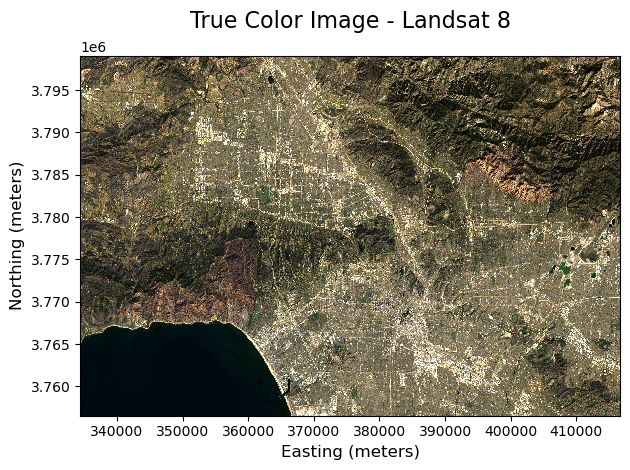

In [8]:
# Create true color composite with robust scaling
landsat[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
plt.title('True Color Image - Landsat 8', fontsize=16, pad=20)
plt.xlabel('Easting (meters)', fontsize=12)
plt.ylabel('Northing (meters)', fontsize=12)
plt.tight_layout()
plt.show()

The `robust=True` parameter clips extreme outlier values to improve visualization, preventing a few bright pixels from washing out the entire image.

## False Color Analysis

False color composites use non-visible wavelengths to reveal features invisible to the human eye. By assigning shortwave infrared (SWIR) to red, near-infrared (NIR) to green, and red to blue, we create an image where:

- **Healthy vegetation** appears bright green (high NIR reflectance, low SWIR reflectance)
- **Burned areas** appear reddish-brown (low NIR reflectance, moderate SWIR reflectance)
- **Urban areas** appear in neutral tones (moderate reflectance across bands)

This band combination is particularly effective for identifying burn scars and assessing vegetation health after wildfires.

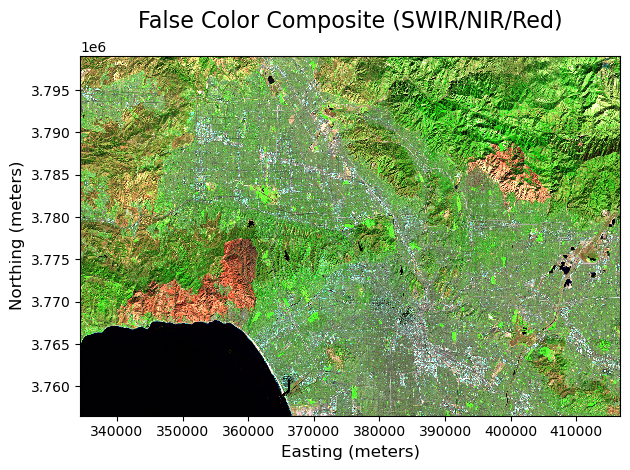

In [9]:
# Create false color composite (SWIR/NIR/Red)
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(robust=True)
plt.title('False Color Composite (SWIR/NIR/Red)', fontsize=16, pad=20)
plt.xlabel('Easting (meters)', fontsize=12)
plt.ylabel('Northing (meters)', fontsize=12)
plt.tight_layout()
plt.show()

**Why this band combination?**

The SWIR/NIR/Red false color composite enhances our ability to distinguish burned areas from healthy vegetation:

- Vegetation has high near-infrared reflectance (due to leaf cell structure) but absorbs shortwave infrared (due to water content)
- Burned areas have reduced NIR reflectance (no healthy vegetation) and increased SWIR reflectance (exposed soil and ash)
- This spectral difference creates strong visual contrast between healthy (green) and burned (brown/red) areas

## Creating the Final Map

To provide geographic context, we overlay the fire perimeters onto our false color image. This requires reprojecting the vector data to match the raster's coordinate system (EPSG:32611 - UTM Zone 11N).

**Why reproject?** Spatial operations and accurate overlays require all datasets to share the same CRS. Since the fire perimeters use EPSG:3857 (Web Mercator) and the Landsat data uses EPSG:32611 (UTM), we convert the vectors to match the raster.

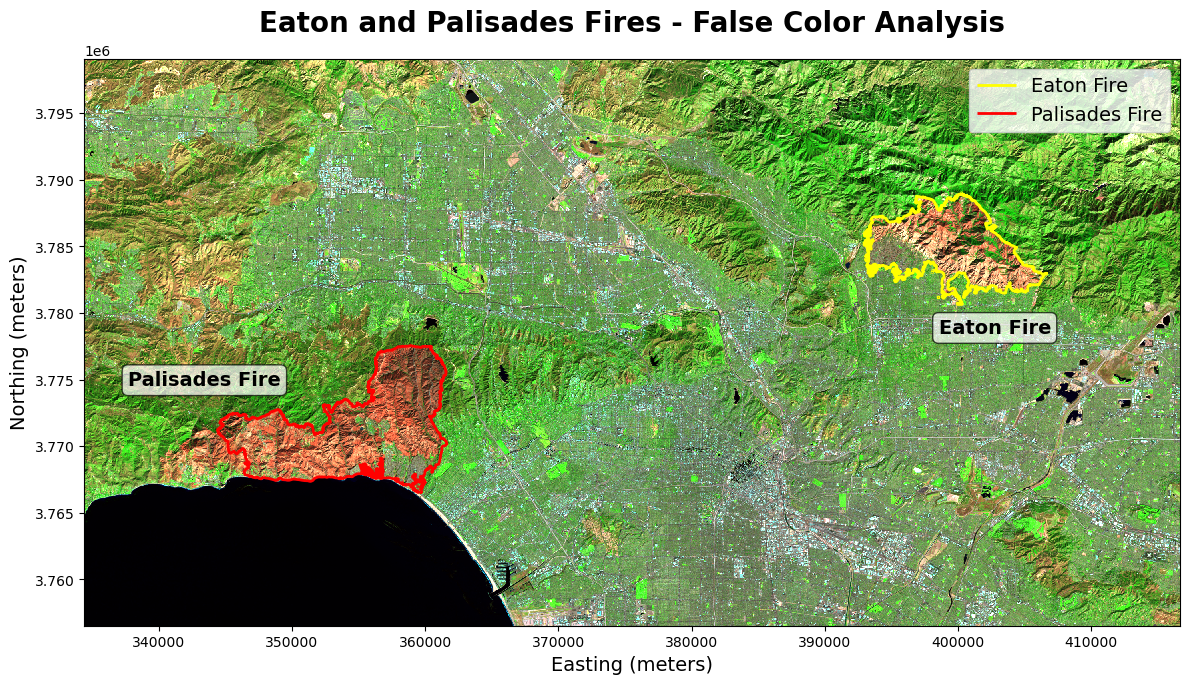

In [10]:
# Reproject fire perimeters to match Landsat CRS
eaton = eaton.to_crs(landsat.rio.crs)
palisades = palisades.to_crs(landsat.rio.crs)

# Create comprehensive map
fig, ax = plt.subplots(figsize=(12, 12))

# Plot false color composite
landsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(
    ax=ax,
    robust=True,
    add_colorbar=False
)

# Overlay fire perimeters with distinct colors
eaton.boundary.plot(ax=ax, edgecolor='yellow', linewidth=2, label='Eaton Fire')
palisades.boundary.plot(ax=ax, edgecolor='red', linewidth=2, label='Palisades Fire')

# Add labels and formatting
plt.title('Eaton and Palisades Fires - False Color Analysis',
          fontsize=20, fontweight='bold', pad=20)
plt.legend(loc='upper right', fontsize=14)
ax.set_xlabel('Easting (meters)', fontsize=14)
ax.set_ylabel('Northing (meters)', fontsize=14)

# Add fire name annotations for clarity
ax.text(eaton.geometry.centroid.x.values[0],
        eaton.geometry.centroid.y.values[0] - 2700,
        'Eaton Fire',
        color='black', fontsize=14, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax.text(palisades.geometry.centroid.x.values[0] - 22000,
        palisades.geometry.centroid.y.values[0] + 8000,
        'Palisades Fire',
        color='black', fontsize=14, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

## Figure Interpretation

This false color composite displays the Eaton and Palisades fire areas captured by Landsat 8 on February 23, 2025. The image uses **shortwave infrared (SWIR)**, **near-infrared (NIR)**, and **red** bands to highlight burn scars and vegetation health.

**Key features:**

- **Bright green areas** = Healthy vegetation (high NIR reflectance)
- **Reddish-brown areas** = Burned areas and bare soil (low NIR, moderate SWIR)
- **Urban/developed areas** = Neutral tones (moderate reflectance across bands)

The fire perimeters are overlaid in **yellow (Eaton Fire)** and **red (Palisades Fire)** to delineate the official burn boundaries. This false color combination is particularly effective for assessing fire severity and monitoring landscape recovery, as the spectral signatures of healthy vs. burned vegetation are distinctly different in the infrared wavelengths.

**Notable observations:**

- The Eaton Fire (northern/eastern area) shows extensive burn scarring in the foothill regions
- The Palisades Fire (western area) burned through coastal vegetation and developed areas
- Surrounding unburned areas maintain their characteristic green appearance, indicating healthy vegetation
- The sharp contrast between burned and unburned areas demonstrates the effectiveness of this false color technique for fire damage assessment